In [ ]:
### Imports 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import load_model
import re
from matplotlib.gridspec import GridSpec
import seaborn as sb
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVR, SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

## The Aim in this notebook is to study the performances of the Random Forest Regressor algorithm for the specific task of predicting the prices of Airbnb listings in Berlin. 

## I / Preprocessing 

After deeply exploring the data ( see the file Analyse de données ), Chris sent us a preprocessing version of the data, that will be our base for this notebook

In [ ]:
## Importing raw data 
train_data = pd.read_csv('train_airbnb_berlin.csv', sep=',')
## to use the notebook, use this line : ( I used the one before because I worked on colab)
## train_data = pd.read_csv('../../data/train_airbnb_berlin.csv', sep=',')
train_data.head()

,Listing ID,Listing Name,Host ID,Host Name,Host Since,Host Response Time,Host Response Rate,Is Superhost,neighbourhood,Neighborhood Group,...,Overall Rating,Accuracy Rating,Cleanliness Rating,Checkin Rating,Communication Rating,Location Rating,Value Rating,Instant Bookable,Business Travel Ready,Price
0,19665213.0,*,156079597.0,Maximilian,2016-01-20,NaN,NaN,f,Prenzlauer Berg,Pankow,...,100.0,10.0,10.0,10.0,10.0,9.0,10.0,t,f,26.0
1,6436842.0,*,5302290.0,Dulie,2013-04-07,NaN,NaN,f,Pankow,Pankow,...,90.0,9.0,9.0,10.0,10.0,9.0,10.0,f,f,41.0
2,10559468.0,*,59151456.0,Geank,2016-02-07,NaN,NaN,f,Prenzlauer Berg,Pankow,...,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f,f,50.0
3,27215482.0,*,193452785.0,Alix,2018-06-26,NaN,NaN,f,Friedrichshain,Friedrichshain-Kreuzberg,...,100.0,10.0,10.0,10.0,10.0,10.0,9.0,f,f,50.0
4,27287546.0,*,205870244.0,Lurina,2013-05-16,within a few hours,92%,t,Prenzlauer Berg,Pankow,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,t,f,55.0


From this database we will drop a few lines that we considered to not be so usefull Among them:
- Postal Code : All the information is in the neighbourhood and latitude / longitude 

- neighborhood : At first we decided to drop "Neighborhood Group" and keep the column "neighborhood". And we would impute the values of the neighborhood by getting the neighborhood of the listing with the closest latitude and longitude. However for the case of Random Forest I ran a first version and got the features with the most importance and noticed that only 3 neighborhood were actually relevant ( out of 63 ) and that those neighborhood have their own Neighborhood Group. So change of plan, we will drop the neighborhoods ! 

- Country Code, City and Business Travel Ready : All the same 


In [ ]:
### Chris' function : 

def preprocess_data_preliminary(df):
    df_clean = df.drop(["Host ID","Listing ID", "Listing Name", "neighbourhood","City","Country Code","Country","Postal Code","Square Feet", "First Review",
                        "Last Review","Business Travel Ready"], axis=1)


    # Dropping NaNs where it doesn't pose a problem. Merely 3% of the entire dataset.

    df_clean = df_clean.dropna(subset=["Host Name", "Host Since","Is Superhost","Property Type","Accomodates","Bathrooms","Bedrooms","Beds",
                                       "Guests Included","Min Nights","Price"])

    # Let's fill NaN values by "unknown" where we can.  

    df_clean.loc[df_clean['Host Response Time'].isna(), "Host Response Time"]='unknown'

    # Replacing binary values by 0 and 1

    df_clean.loc[df_clean["Is Superhost"]=='t', "Is Superhost"]=1
    df_clean.loc[df_clean["Is Superhost"]=='f', "Is Superhost"]=0
    df_clean["Is Superhost"]=df_clean["Is Superhost"].astype(float)    

    df_clean.loc[df_clean["Is Exact Location"]=='t', "Is Exact Location"]=1
    df_clean.loc[df_clean["Is Exact Location"]=='f', "Is Exact Location"]=0
    df_clean["Is Exact Location"]=df_clean["Is Superhost"].astype(float)    

    df_clean.loc[df_clean["Instant Bookable"]=='t', "Instant Bookable"]=1
    df_clean.loc[df_clean["Instant Bookable"]=='f', "Instant Bookable"]=0
    df_clean["Instant Bookable"]=df_clean["Is Superhost"].astype(float)

    # Converting into float certain features were apparently value isn't seen as numeric

    df_clean["Accomodates"]=df_clean["Accomodates"].astype(float)
    df_clean["Bathrooms"]=df_clean["Bathrooms"].astype(float)
    df_clean["Bedrooms"]=df_clean["Bedrooms"].astype(float)      
    df_clean["Beds"]=df_clean["Beds"].astype(float)          
    df_clean["Guests Included"]=df_clean["Guests Included"].astype(float)
    df_clean["Min Nights"]=df_clean["Min Nights"].astype(float)

    # String to float for response rate.
    df_clean["Host Response Rate"] = df_clean["Host Response Rate"].str.rstrip("%").astype(float)

    # Changing host since into continous form.

    df_clean["Host Since"] = pd.to_datetime(df_clean["Host Since"])
    most_recent =  max(df_clean["Host Since"])
    seniority = [(most_recent-x).days for x in df_clean["Host Since"]]
    df_clean["Host Since"] = seniority

    # One-hot encoding for categorical values

    dummies_response_time  = pd.get_dummies(df_clean[["Host Response Time"]])
    dummies_property_type = pd.get_dummies(df_clean[["Property Type"]])
    dummies_room_type = pd.get_dummies(df_clean[["Room Type"]])
    dummies_neighborhood_group = pd.get_dummies(df_clean[["Neighborhood Group"]])
  

    X_ = df_clean.drop(["Host Response Time", "Property Type", "Room Type", "Neighborhood Group"],axis=1)
    df_clean_final = pd.concat([X_, dummies_response_time, dummies_property_type, dummies_room_type, dummies_neighborhood_group], axis=1)

    return df_clean_final

In [ ]:
train_data[train_data == "*"] = np.nan
df_data = preprocess_data_preliminary(train_data)

In [ ]:
df_data.columns

In [ ]:
# Renaming  

## Loadings 
pred_model = load_model('boyorgirl.h5')

## preprocess 

def preprocess(names_df):

    names_df['Host Name'] = names_df['Host Name'].apply(lambda x: 'nan' if type(x)!=type('hello') else x)

    names_df['Host Name'] = names_df['Host Name'].apply(lambda x: 'nan' if  bool(re.match("^[A-Za-z0-9_-]*$",x))==False else x)

    names_df['name']= names_df['Host Name']
    names_df['name'] = names_df['name'].str.lower()

    names_df['name'] = [list(name) for name in names_df['name']]

    name_length = 50
    names_df['name'] = [
        (name + [' ']*name_length)[:name_length] 
        for name in names_df['name']
    ]

    names_df['name'] = [
        [
            max(0.0, ord(char)-96.0) 
            for char in name
        ]
        for name in names_df['name']
    ]

    return names_df


### prediction 

df_data_renamed = preprocess(df_data)

result = pred_model.predict(np.array(df_data_renamed['name'].tolist()))

df_data_renamed['Boy or Girl?'] = [
        'Boy' if logit > 0.5 else 'Girl' for logit in result
    ]

df_data_renamed.drop('name', axis=1, inplace=True)

dummies_gender = pd.get_dummies(df_data_renamed[["Boy or Girl?"]])

X_ = df_data_renamed.drop(["Boy or Girl?"],axis=1)
df_data_2 = pd.concat([X_,  dummies_gender], axis=1)

478/478 [==============================] - 23s 46ms/step


- Host Name : was used to determine wether the Name of the Host seemed like a "woman" or a "man" name with NLP :). So we have no more use for this column 

In [ ]:
df_data_2.drop('Host Name', axis=1, inplace=True)

In [ ]:
## Paul's code : 
s_latitude =  df_data_2["Latitude"].sum()
s_longitude =  df_data_2["Longitude"].sum()

barycentre_lat = s_latitude/len( df_data_2)
barycentre_long = s_longitude/len( df_data_2)

df_data_2["Distance from barycenter"] = np.sqrt(( df_data_2["Latitude"] - barycentre_lat)**2
                                              + ( df_data_2["Longitude"] - barycentre_long)**2)

In [ ]:
df_data_2.columns

In [ ]:
df_data_2.to_csv("train_airbnb_berlin_preprocessed_phase2.csv", sep=";", index=False)

## II / Split to obtain the Train - Test sets

In [ ]:
df_data_2 = pd.read_csv('train_airbnb_berlin_preprocessed_phase2.csv', sep=';')
## df_data_2 = pd.read_csv('../../data/train_airbnb_berlin_preprocessed_phase2.csv', sep=';')
df_data_2.head()

,Host Since,Host Response Rate,Is Superhost,Latitude,Longitude,Is Exact Location,Accomodates,Bathrooms,Bedrooms,Beds,...,Neighborhood Group_NeukÃ¶lln,Neighborhood Group_Pankow,Neighborhood Group_Reinickendorf,Neighborhood Group_Spandau,Neighborhood Group_Steglitz - Zehlendorf,Neighborhood Group_Tempelhof - SchÃ¶neberg,Neighborhood Group_Treptow - KÃ¶penick,Boy or Girl?_Boy,Boy or Girl?_Girl,Distance from barycenter
0,1206,NaN,0.0,52.54652,13.41792,0.0,2.0,1.0,1.0,1.0,...,0,1,0,0,0,0,0,1,0,0.038097
1,2224,NaN,0.0,52.56512,13.42214,0.0,2.0,1.0,2.0,2.0,...,0,1,0,0,0,0,0,0,1,0.057150
2,1188,NaN,0.0,52.54741,13.42521,0.0,3.0,1.0,1.0,2.0,...,0,1,0,0,0,0,0,1,0,0.041516
3,318,NaN,0.0,52.50958,13.45144,0.0,2.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,1,0.044018
4,2185,92.0,1.0,52.52995,13.41558,1.0,3.0,1.0,1.0,2.0,...,0,1,0,0,0,0,0,0,1,0.021648


In [ ]:
y = df_data_2['Price']
X = df_data_2.drop(['Price'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f49ba76fd10>,
      dtype=object)

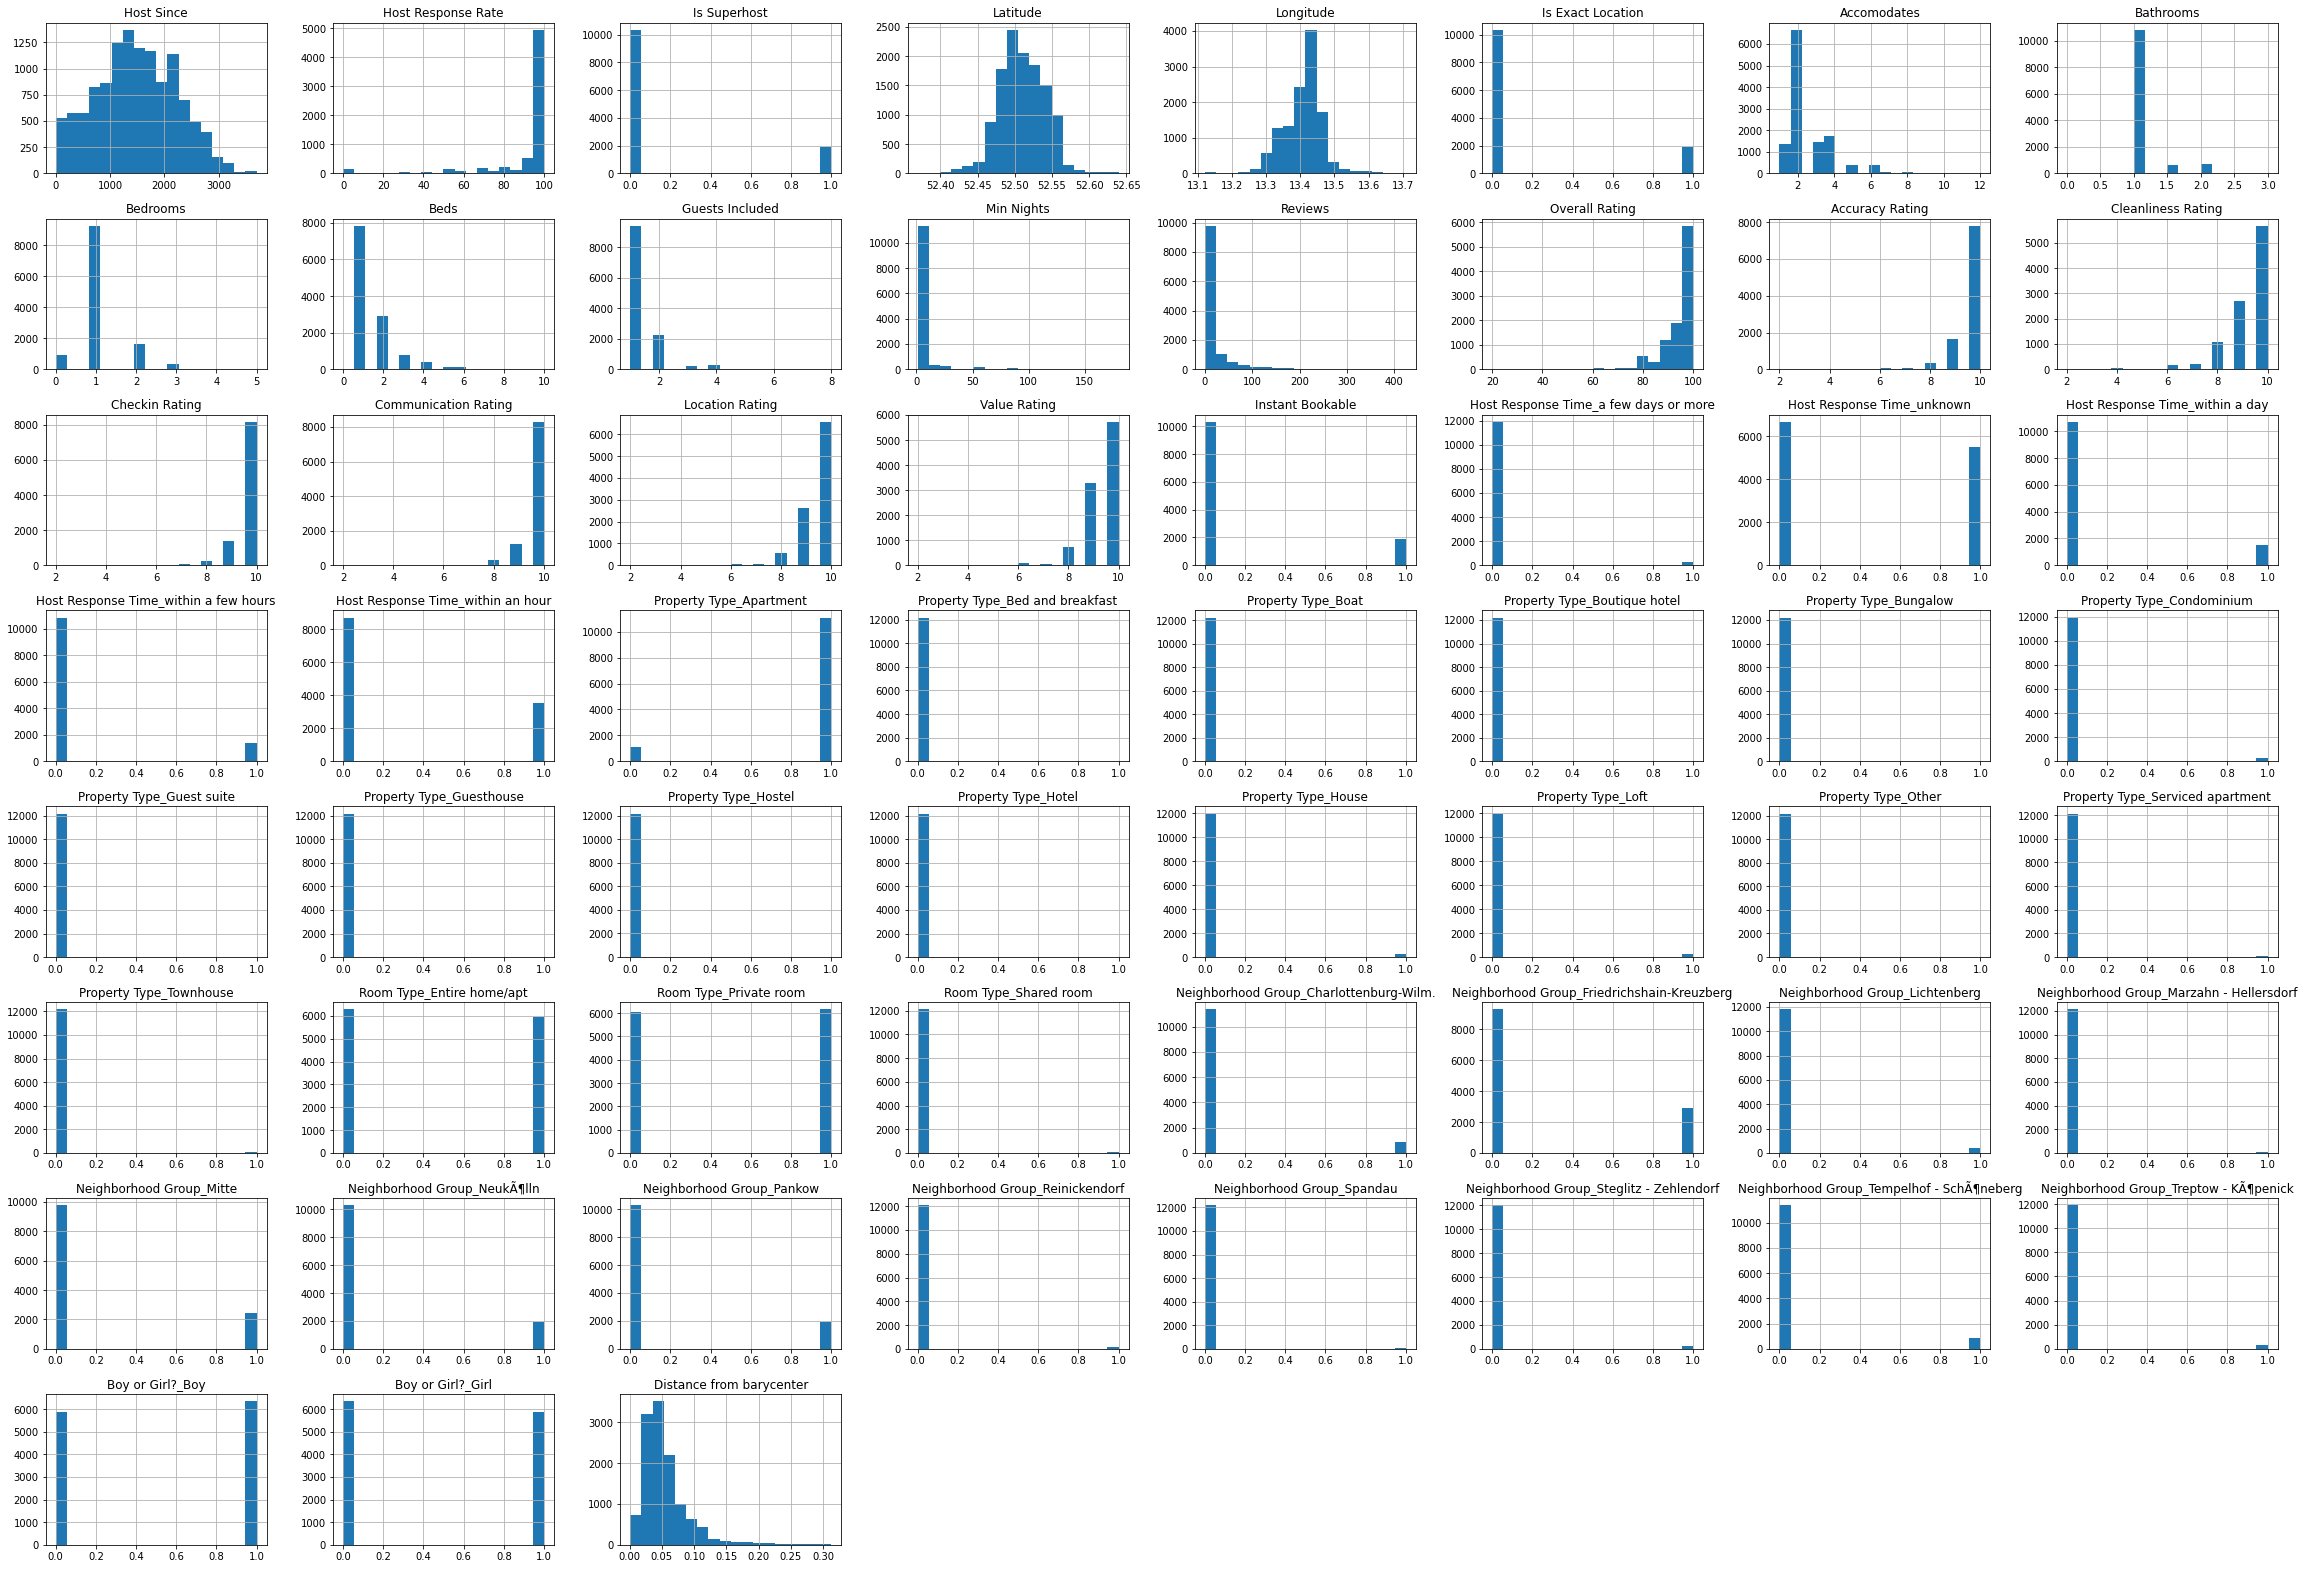

In [ ]:
X_train.hist(figsize=(40,28), bins=18)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f49b3efa850>,
      dtype=object)

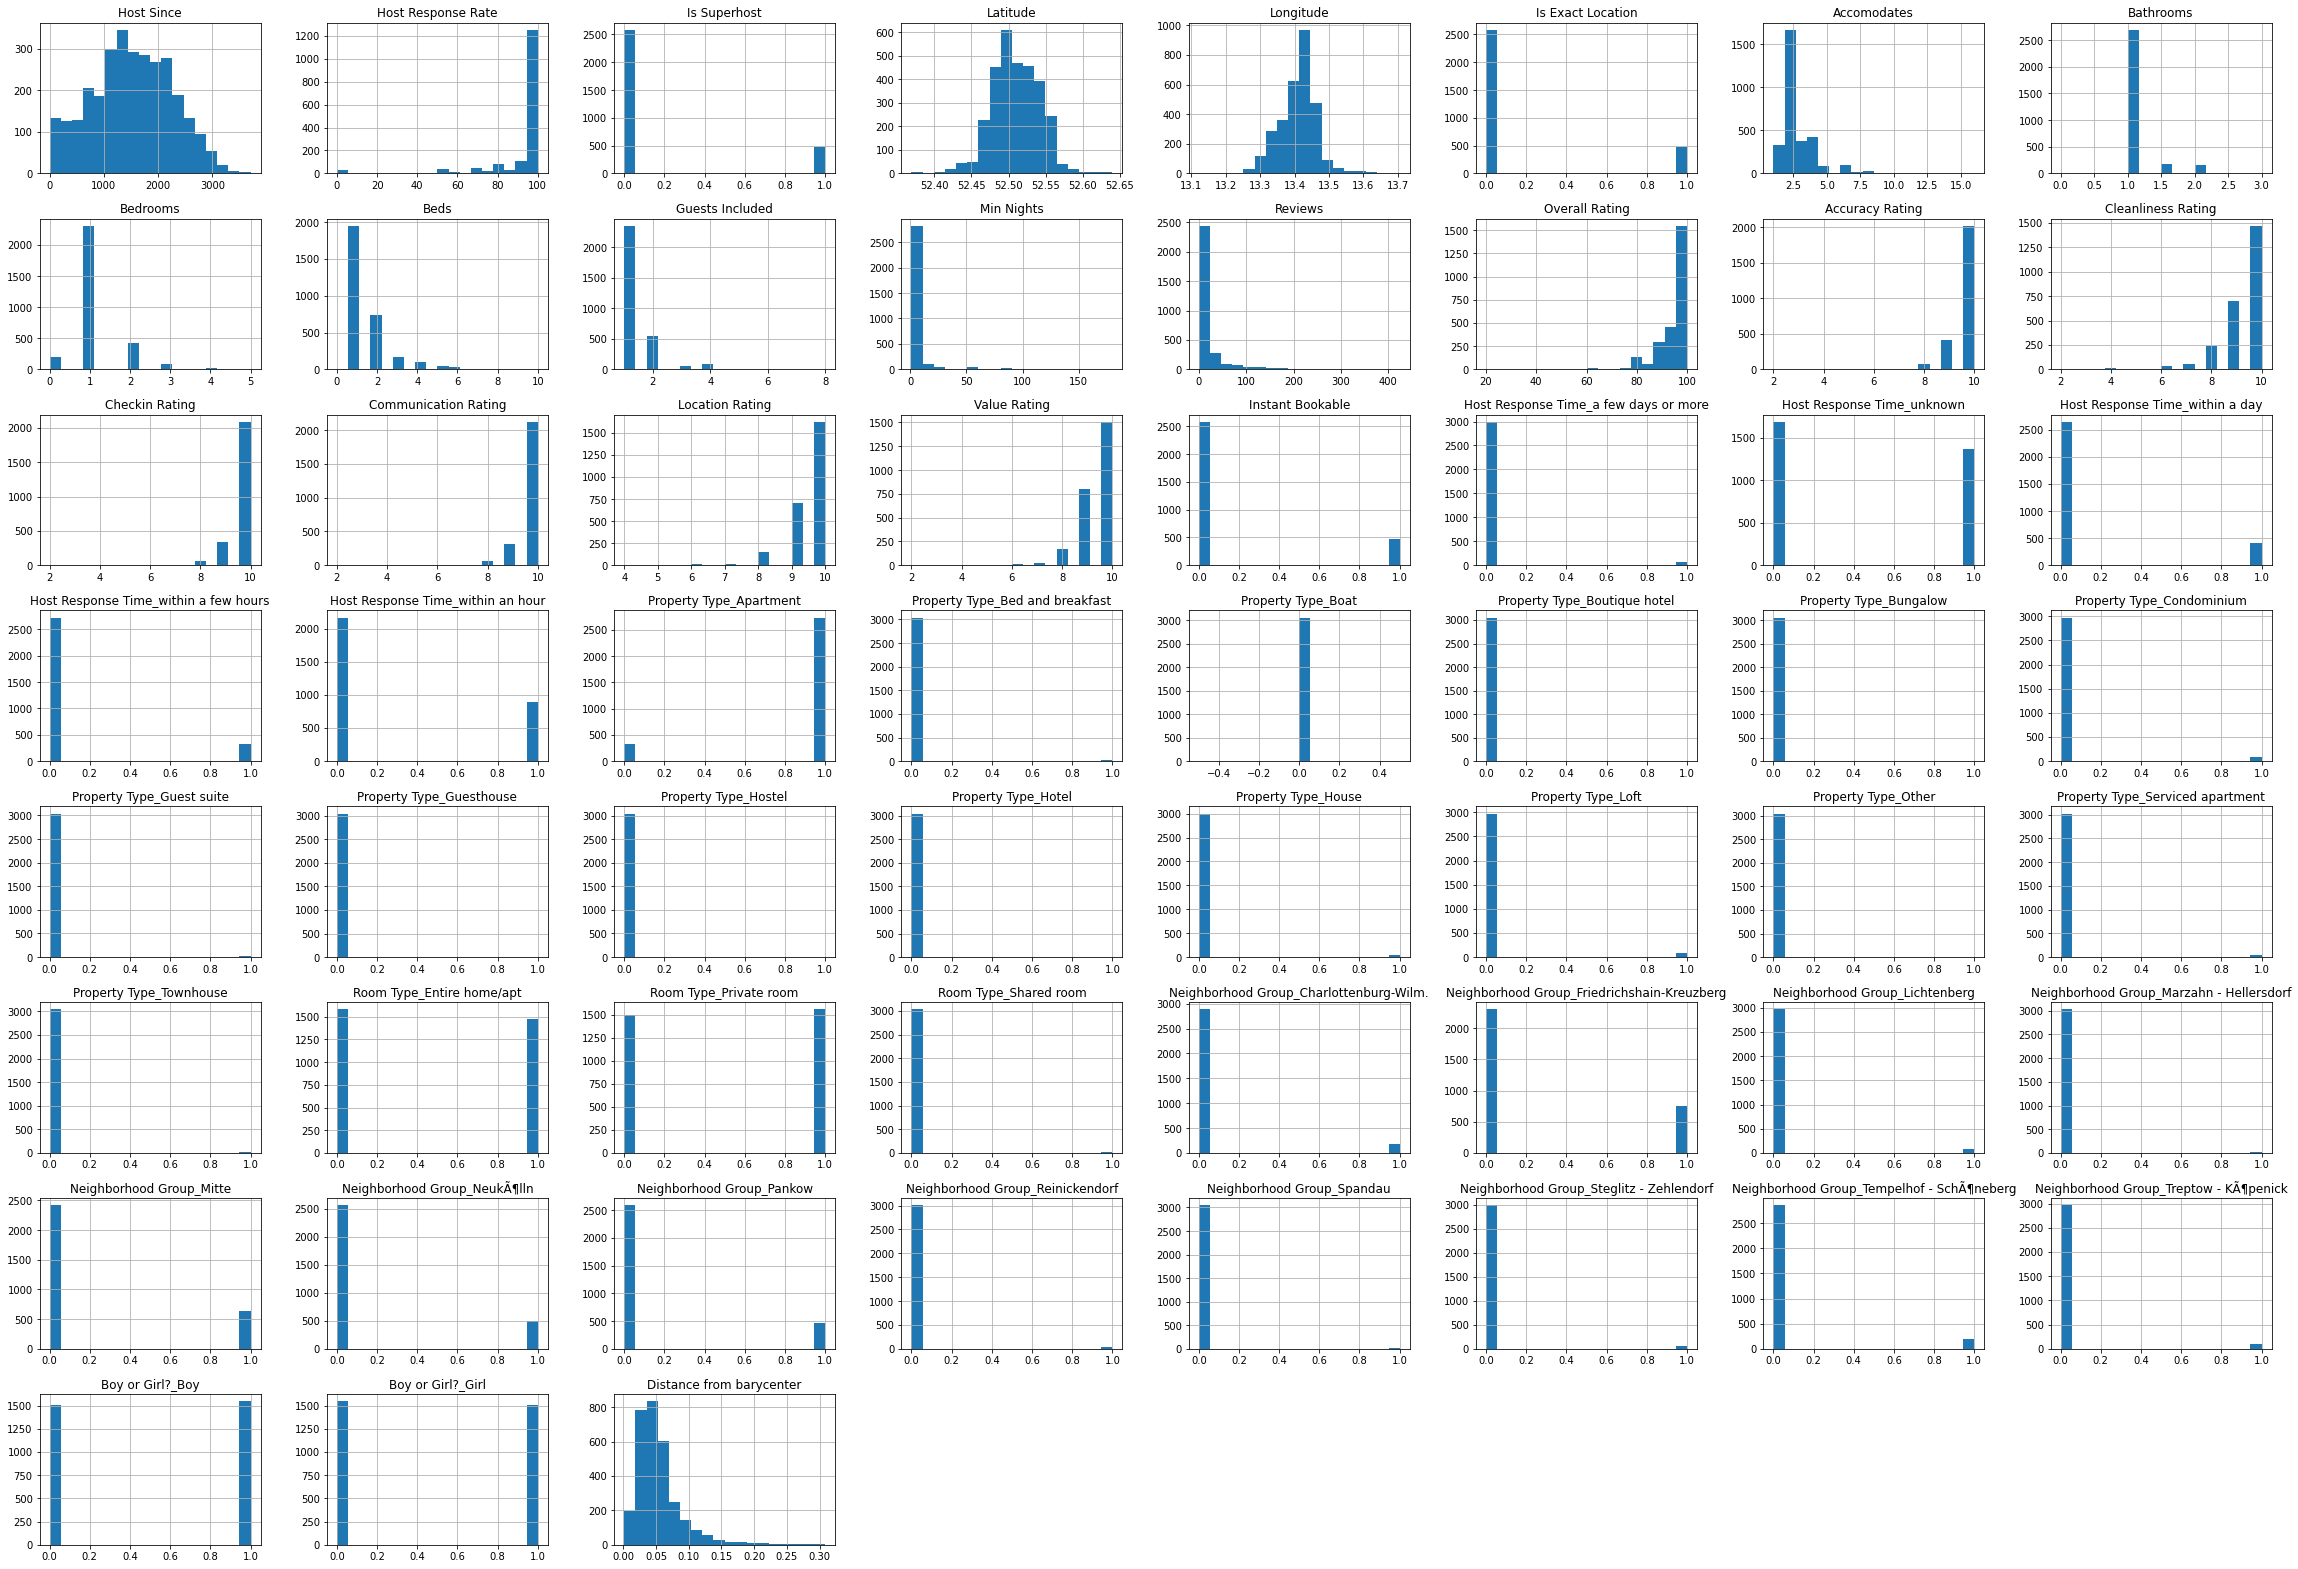

In [ ]:
X_test.hist(figsize=(40,28), bins=18)

We can see that the split kept more less the same repartition 

## III/ First rough application of the algorithm as Random Forest Regressor can take in not standarized data 

Here we will do a rough imputation with the mean value and see what we get. We will see if that's the best solution later on 

In [ ]:
from sklearn.impute import SimpleImputer
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(X_train)
X_train_imp = imp_mean.transform(X_train)

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(X_test)
X_test_imp = imp_mean.transform(X_test)

## Definition of the model 
model_rf = RandomForestRegressor(n_estimators=200)
## Fit of the model 
model_rf.fit(X_train_imp, y_train)
## Predict on the test 
y_train_pred = model_rf.predict(X_test_imp)

## Metrics 
mse = mean_squared_error(y_train_pred, y_test)
mae = mean_absolute_error(y_train_pred, y_test)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_train_pred)

### Printing the metrics 
print(f'MSE : {mse}')
print(f'MAE : {mae}')
print(f'RMSE: {rmse}')
print(f'R2 Score: {r2}')



MSE : 1110.3688242796331
MAE : 20.573215455140797
RMSE: 33.322197170649375
R2 Score: 0.4392548472393176


We get the values :

- MSE : 1110.3688242796331
- MAE : 20.573215455140797
- RMSE: 33.322197170649375
- R2 Score: 0.4392548472393176

The results are not too bad for a first version of the model.

## IV/ Now let's try to make this algorithme better ! 

###A/ What type of imputation ? 

We will test 2 types of imputations for our missing data, as in our case there is no need of doing anything else than :
- Mean 
- Median 

In [ ]:
## Mean 

pipe = Pipeline([('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
                    ('rf', RandomForestRegressor(n_estimators=400))])

pipe.fit(X_train, y_train)

y_train_pred = pipe.predict(X_test)

## Metrics 
mse = mean_squared_error(y_train_pred, y_test)
mae = mean_absolute_error(y_train_pred, y_test)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_train_pred)

### Printing the metrics 
print(f'MSE : {mse}')
print(f'MAE : {mae}')
print(f'RMSE: {rmse}')
print(f'R2 Score: {r2}')

MSE : 1141.7095364890308
MAE : 20.70412082514735
RMSE: 33.78919259895138
R2 Score: 0.4234275364654505


In [ ]:
## Median 
pipe = Pipeline([('imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
                    ('rf', RandomForestRegressor(n_estimators=400))])

pipe.fit(X_train, y_train)

y_train_pred = pipe.predict(X_test)

## Metrics 
mse = mean_squared_error(y_train_pred, y_test)
mae = mean_absolute_error(y_train_pred, y_test)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_train_pred)

### Printing the metrics 
print(f'MSE : {mse}')
print(f'MAE : {mae}')
print(f'RMSE: {rmse}')
print(f'R2 Score: {r2}')

MSE : 1134.2196772061232
MAE : 20.5996201702685
RMSE: 33.67817805651195
R2 Score: 0.4272099754135854


Median imputation seems better with an mse of 134.2196772061232. Let's go with that ! 

### B/ What type of standardization ? 

Random Forest Classifiers are not so much affected by data normalization. Let's see if it is the case for Random Forest Regressors. To do that we will see the results for **not normalized data**, for **min-max normalization** and **Standardization**. 

In [ ]:
# Regression
pipe = Pipeline([('imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
                    ('rf', RandomForestRegressor(n_estimators=400))])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print(f'Accuracy score without normalization: {mean_squared_error(y_test, y_pred)}')

## Min-max normalization
pipe = Pipeline([('imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
                 ('scaler',MinMaxScaler()),
                 ('rf', RandomForestRegressor(n_estimators=400))])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print(f'Accuracy score with min-max normalization: {mean_squared_error(y_test, y_pred)}')
      
## Standardization

pipe = Pipeline([('imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
                    ('scaler', StandardScaler()),
                    ('rf', RandomForestRegressor())])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print(f'Accuracy score with standardization: {mean_squared_error(y_test, y_pred)}')

Accuracy score without normalization: 1133.723295831287
Accuracy score with min-max normalization: 1131.131694785527
Accuracy score with standardization: 1150.683522167649


The scores we get are : 

- Accuracy score without normalization: 1133.723295831287
- Accuracy score with min-max normalization: 1131.131694785527
- Accuracy score with standardization: 1150.683522167649

The scores are not that different however we can see that min-max normalization does improve the score. So let's go with that for the rest of our algorithms ! 

### B/ Random Search 

For the random search we will do a first test only looking for n_estimators and max_depth 

In [ ]:
## Changing X_train 
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
imp_median.fit(X_train)
X_train_imp = imp_median.transform(X_train)

scaler = MinMaxScaler()
scaler.fit(X_train_imp)
X_train_imp = scaler.transform(X_train_imp)

## Random Search : 
rf = RandomForestRegressor()
param = {'n_estimators':[200,300,400,500], 'max_depth':[3,5,10,15,30]}
random_search = RandomizedSearchCV(rf, param, scoring='neg_root_mean_squared_error', n_iter=10, cv=5, n_jobs=-1, verbose=10, random_state=42)

random_search.fit(X_train_imp, y_train)
results = pd.DataFrame.from_dict(random_search.cv_results_)
random_search.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


RandomForestRegressor(max_depth=5, n_estimators=300)

In [ ]:
print(f'Best parameters are {random_search.best_params_}') 
print(f'Best score is {random_search.best_score_ * -1}')
print(f'Best model is {random_search.best_estimator_}')
print("scores {}".format(random_search.cv_results_['mean_test_score']))

Best parameters are {'n_estimators': 300, 'max_depth': 5}
Best score is 38.898280860697376
Best model is RandomForestRegressor(max_depth=5, n_estimators=300)
scores [-39.5281817  -39.61814294 -39.47217223 -39.52700423 -39.29439204
 -38.89828086 -39.27679984 -39.54011187 -39.47558558 -39.58452575]


Based on this, we will go with n_estimators = 300 and max_depth = 5 
But let's try with more hyperparameter to see if we can get a better result 

In [ ]:
## Changing X_train 
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
imp_median.fit(X_train)
X_train_imp = imp_median.transform(X_train)

scaler = MinMaxScaler()
scaler.fit(X_train_imp)
X_train_imp = scaler.transform(X_train_imp)

## Random Search : 
rf = RandomForestRegressor()
param = {'n_estimators':[200,300,400],
          'max_depth':[5,10,20,30],
          'max_features': ['auto', 'sqrt'],
          'min_samples_leaf': [1, 3],
          'min_samples_split': [2, 7],
}

random_search = RandomizedSearchCV(rf, param, scoring='neg_root_mean_squared_error', n_iter=10, cv=5, n_jobs=-1, verbose=10, random_state=42)

random_search.fit(X_train_imp, y_train)
results = pd.DataFrame.from_dict(random_search.cv_results_)
random_search.best_estimator_

print(f'Best parameters are {random_search.best_params_}') 
print(f'Best score is {random_search.best_score_ * -1}')
print(f'Best model is {random_search.best_estimator_}')
print("scores {}".format(random_search.cv_results_['mean_test_score']))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters are {'n_estimators': 300, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'max_depth': 30}
Best score is 37.90289400973615
Best model is RandomForestRegressor(max_depth=30, max_features='sqrt', min_samples_leaf=3,
                      min_samples_split=7, n_estimators=300)
scores [-38.56517514 -39.27374459 -39.50568298 -37.90289401 -38.46517023
 -38.54938088 -37.9336994  -38.10573949 -38.95014913 -38.83081882]


In [ ]:
pipe = Pipeline([('imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
                 ('scaler',MinMaxScaler()),
                 ('rf', RandomForestRegressor(n_estimators= 300, min_samples_split= 7, min_samples_leaf= 3, max_features='sqrt', max_depth= 30))])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

## Metrics 
mse = mean_squared_error(y_pred, y_test)
mae = mean_absolute_error(y_pred, y_test)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

### Printing the metrics 
print(f'MSE : {mse}')
print(f'MAE : {mae}')
print(f'RMSE: {rmse}')
print(f'R2 Score: {r2}')

MSE : 1011.2650958967453
MAE : 19.672160455648807
RMSE: 31.800394587123368
R2 Score: 0.4893030241117805


We clearly get a better result ! 

### D/ Feature selection 

Random Forest don't necessarly need to do a feature selection. As it is itself a method to do feature selection because each tree will consider a small amount of features, thus Random Forest is not really concerned by the curse of dimentionality. But we will proceed with a forward feature selection just to see and so that we can compare it with what the random forest features selector  will tell us in terms of number of important features. 

We will do this selection on only n_estimators = 10, I know it is not great but it is mainly to get a general idea, as I tried to run it for n_estimators = 100 and it took hours without finishing, so we will do the test with only n_estimators=10 

In [41]:
## Changing X_train 
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
imp_median.fit(X_train)
X_train_imp = imp_median.transform(X_train)

scaler = StandardScaler()
scaler.fit(X_train_imp)
X_train_imp = scaler.transform(X_train_imp)

X_train_imp = pd.DataFrame(X_train_imp, columns=X_train.columns)

## X_test 
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
imp_median.fit(X_test)
X_test_imp = imp_median.transform(X_test)

scaler = StandardScaler()
scaler.fit(X_test_imp)
X_test_imp = scaler.transform(X_test_imp)
X_test_imp = pd.DataFrame(X_test_imp, columns=X_test.columns)

In [42]:
from sklearn.model_selection import KFold
from sklearn import model_selection

model = RandomForestRegressor(n_estimators=10).fit(X_train_imp,y_train)
kf_10 = model_selection.KFold(n_splits=10, shuffle=True, random_state=0)

def processSubset(feature_set):
    
    # Fit decision tree model on feature_set and calculate score
    score = -1 * model_selection.cross_val_score(model, X_train_imp[list(feature_set)],
                                                 y_train.ravel(),
                                                 cv=kf_10,
                                                 scoring='neg_mean_squared_error').mean()

    return {"model":list(feature_set), "MSE":score}

In [43]:
import time 
import itertools

def forward(features):

    # Pull out features we still need to process
    remaining_features = [d for d in X_train_imp.columns if d not in features]

    tic = time.time()
    
    results = []
    
    for d in remaining_features:
        results.append(processSubset(features+[d]))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    
    best_model = models.loc[models['MSE'].argmin()]
    
    toc = time.time()

    print("Processed", models.shape[0], "models on", len(features)+1, "features in", (toc-tic), "seconds.")
    
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [44]:
from tqdm import tqdm
models_fwd = pd.DataFrame(columns=["model","MSE"])
features = []
tic = time.time()
header = ["feature set", "RSS"]

for i in tqdm(range(1,len(X_train_imp.columns)+1)):    
    models_fwd.loc[i] = forward(features)
    features = models_fwd.loc[i]["model"]
    print(features)
toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

  2%|▏         | 1/59 [00:20<20:08, 20.83s/it]

Processed 59 models on 1 features in 20.826380014419556 seconds.
['Accomodates']


  3%|▎         | 2/59 [00:55<27:14, 28.68s/it]

Processed 58 models on 2 features in 34.164703130722046 seconds.
['Accomodates', 'Room Type_Entire home/apt']


  5%|▌         | 3/59 [01:19<25:04, 26.86s/it]

Processed 57 models on 3 features in 24.680186986923218 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms']


  7%|▋         | 4/59 [01:47<25:06, 27.39s/it]

Processed 56 models on 4 features in 28.19640302658081 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Property Type_Apartment']


  8%|▊         | 5/59 [02:20<26:11, 29.10s/it]

Processed 55 models on 5 features in 32.12697243690491 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Property Type_Apartment', 'Property Type_Hotel']


 10%|█         | 6/59 [02:52<26:35, 30.10s/it]

Processed 54 models on 6 features in 32.023361921310425 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Property Type_Apartment', 'Property Type_Hotel', 'Accuracy Rating']


 12%|█▏        | 7/59 [03:29<28:04, 32.39s/it]

Processed 53 models on 7 features in 37.10577034950256 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Property Type_Apartment', 'Property Type_Hotel', 'Accuracy Rating', 'Is Exact Location']


 14%|█▎        | 8/59 [04:10<29:56, 35.22s/it]

Processed 52 models on 8 features in 41.27928447723389 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Property Type_Apartment', 'Property Type_Hotel', 'Accuracy Rating', 'Is Exact Location', 'Property Type_Serviced apartment']


 15%|█▌        | 9/59 [04:51<30:51, 37.03s/it]

Processed 51 models on 9 features in 40.99015998840332 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Property Type_Apartment', 'Property Type_Hotel', 'Accuracy Rating', 'Is Exact Location', 'Property Type_Serviced apartment', 'Property Type_House']


 17%|█▋        | 10/59 [05:33<31:29, 38.56s/it]

Processed 50 models on 10 features in 41.97324752807617 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Property Type_Apartment', 'Property Type_Hotel', 'Accuracy Rating', 'Is Exact Location', 'Property Type_Serviced apartment', 'Property Type_House', 'Neighborhood Group_Marzahn - Hellersdorf']


 19%|█▊        | 11/59 [06:16<31:56, 39.93s/it]

Processed 49 models on 11 features in 43.03951144218445 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Property Type_Apartment', 'Property Type_Hotel', 'Accuracy Rating', 'Is Exact Location', 'Property Type_Serviced apartment', 'Property Type_House', 'Neighborhood Group_Marzahn - Hellersdorf', 'Property Type_Hostel']


 20%|██        | 12/59 [06:59<32:07, 41.01s/it]

Processed 48 models on 12 features in 43.464903593063354 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Property Type_Apartment', 'Property Type_Hotel', 'Accuracy Rating', 'Is Exact Location', 'Property Type_Serviced apartment', 'Property Type_House', 'Neighborhood Group_Marzahn - Hellersdorf', 'Property Type_Hostel', 'Property Type_Boat']


 22%|██▏       | 13/59 [07:44<32:10, 41.96s/it]

Processed 47 models on 13 features in 44.15874171257019 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Property Type_Apartment', 'Property Type_Hotel', 'Accuracy Rating', 'Is Exact Location', 'Property Type_Serviced apartment', 'Property Type_House', 'Neighborhood Group_Marzahn - Hellersdorf', 'Property Type_Hostel', 'Property Type_Boat', 'Property Type_Guesthouse']


 24%|██▎       | 14/59 [08:27<31:49, 42.42s/it]

Processed 46 models on 14 features in 43.48210549354553 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Property Type_Apartment', 'Property Type_Hotel', 'Accuracy Rating', 'Is Exact Location', 'Property Type_Serviced apartment', 'Property Type_House', 'Neighborhood Group_Marzahn - Hellersdorf', 'Property Type_Hostel', 'Property Type_Boat', 'Property Type_Guesthouse', 'Property Type_Bungalow']


 25%|██▌       | 15/59 [09:10<31:19, 42.71s/it]

Processed 45 models on 15 features in 43.371846437454224 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Property Type_Apartment', 'Property Type_Hotel', 'Accuracy Rating', 'Is Exact Location', 'Property Type_Serviced apartment', 'Property Type_House', 'Neighborhood Group_Marzahn - Hellersdorf', 'Property Type_Hostel', 'Property Type_Boat', 'Property Type_Guesthouse', 'Property Type_Bungalow', 'Neighborhood Group_Spandau']


 27%|██▋       | 16/59 [09:54<30:52, 43.09s/it]

Processed 44 models on 16 features in 43.96263551712036 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Property Type_Apartment', 'Property Type_Hotel', 'Accuracy Rating', 'Is Exact Location', 'Property Type_Serviced apartment', 'Property Type_House', 'Neighborhood Group_Marzahn - Hellersdorf', 'Property Type_Hostel', 'Property Type_Boat', 'Property Type_Guesthouse', 'Property Type_Bungalow', 'Neighborhood Group_Spandau', 'Property Type_Boutique hotel']


 29%|██▉       | 17/59 [10:39<30:31, 43.62s/it]

Processed 43 models on 17 features in 44.82812428474426 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Property Type_Apartment', 'Property Type_Hotel', 'Accuracy Rating', 'Is Exact Location', 'Property Type_Serviced apartment', 'Property Type_House', 'Neighborhood Group_Marzahn - Hellersdorf', 'Property Type_Hostel', 'Property Type_Boat', 'Property Type_Guesthouse', 'Property Type_Bungalow', 'Neighborhood Group_Spandau', 'Property Type_Boutique hotel', 'Property Type_Other']


 31%|███       | 18/59 [11:24<30:06, 44.07s/it]

Processed 42 models on 18 features in 45.11682963371277 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Property Type_Apartment', 'Property Type_Hotel', 'Accuracy Rating', 'Is Exact Location', 'Property Type_Serviced apartment', 'Property Type_House', 'Neighborhood Group_Marzahn - Hellersdorf', 'Property Type_Hostel', 'Property Type_Boat', 'Property Type_Guesthouse', 'Property Type_Bungalow', 'Neighborhood Group_Spandau', 'Property Type_Boutique hotel', 'Property Type_Other', 'Neighborhood Group_Steglitz - Zehlendorf']


 32%|███▏      | 19/59 [12:12<30:03, 45.09s/it]

Processed 41 models on 19 features in 47.47550058364868 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Property Type_Apartment', 'Property Type_Hotel', 'Accuracy Rating', 'Is Exact Location', 'Property Type_Serviced apartment', 'Property Type_House', 'Neighborhood Group_Marzahn - Hellersdorf', 'Property Type_Hostel', 'Property Type_Boat', 'Property Type_Guesthouse', 'Property Type_Bungalow', 'Neighborhood Group_Spandau', 'Property Type_Boutique hotel', 'Property Type_Other', 'Neighborhood Group_Steglitz - Zehlendorf', 'Property Type_Guest suite']


 34%|███▍      | 20/59 [12:59<29:41, 45.67s/it]

Processed 40 models on 20 features in 46.99745059013367 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Property Type_Apartment', 'Property Type_Hotel', 'Accuracy Rating', 'Is Exact Location', 'Property Type_Serviced apartment', 'Property Type_House', 'Neighborhood Group_Marzahn - Hellersdorf', 'Property Type_Hostel', 'Property Type_Boat', 'Property Type_Guesthouse', 'Property Type_Bungalow', 'Neighborhood Group_Spandau', 'Property Type_Boutique hotel', 'Property Type_Other', 'Neighborhood Group_Steglitz - Zehlendorf', 'Property Type_Guest suite', 'Neighborhood Group_Treptow - KÃ¶penick']


 36%|███▌      | 21/59 [13:47<29:28, 46.54s/it]

Processed 39 models on 21 features in 48.57140898704529 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Property Type_Apartment', 'Property Type_Hotel', 'Accuracy Rating', 'Is Exact Location', 'Property Type_Serviced apartment', 'Property Type_House', 'Neighborhood Group_Marzahn - Hellersdorf', 'Property Type_Hostel', 'Property Type_Boat', 'Property Type_Guesthouse', 'Property Type_Bungalow', 'Neighborhood Group_Spandau', 'Property Type_Boutique hotel', 'Property Type_Other', 'Neighborhood Group_Steglitz - Zehlendorf', 'Property Type_Guest suite', 'Neighborhood Group_Treptow - KÃ¶penick', 'Room Type_Shared room']


 37%|███▋      | 22/59 [14:36<29:09, 47.28s/it]

Processed 38 models on 22 features in 48.98607683181763 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Property Type_Apartment', 'Property Type_Hotel', 'Accuracy Rating', 'Is Exact Location', 'Property Type_Serviced apartment', 'Property Type_House', 'Neighborhood Group_Marzahn - Hellersdorf', 'Property Type_Hostel', 'Property Type_Boat', 'Property Type_Guesthouse', 'Property Type_Bungalow', 'Neighborhood Group_Spandau', 'Property Type_Boutique hotel', 'Property Type_Other', 'Neighborhood Group_Steglitz - Zehlendorf', 'Property Type_Guest suite', 'Neighborhood Group_Treptow - KÃ¶penick', 'Room Type_Shared room', 'Property Type_Bed and breakfast']


 39%|███▉      | 23/59 [15:26<28:43, 47.87s/it]

Processed 37 models on 23 features in 49.256617307662964 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Property Type_Apartment', 'Property Type_Hotel', 'Accuracy Rating', 'Is Exact Location', 'Property Type_Serviced apartment', 'Property Type_House', 'Neighborhood Group_Marzahn - Hellersdorf', 'Property Type_Hostel', 'Property Type_Boat', 'Property Type_Guesthouse', 'Property Type_Bungalow', 'Neighborhood Group_Spandau', 'Property Type_Boutique hotel', 'Property Type_Other', 'Neighborhood Group_Steglitz - Zehlendorf', 'Property Type_Guest suite', 'Neighborhood Group_Treptow - KÃ¶penick', 'Room Type_Shared room', 'Property Type_Bed and breakfast', 'Property Type_Townhouse']


 41%|████      | 24/59 [16:16<28:19, 48.57s/it]

Processed 36 models on 24 features in 50.174521684646606 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Property Type_Apartment', 'Property Type_Hotel', 'Accuracy Rating', 'Is Exact Location', 'Property Type_Serviced apartment', 'Property Type_House', 'Neighborhood Group_Marzahn - Hellersdorf', 'Property Type_Hostel', 'Property Type_Boat', 'Property Type_Guesthouse', 'Property Type_Bungalow', 'Neighborhood Group_Spandau', 'Property Type_Boutique hotel', 'Property Type_Other', 'Neighborhood Group_Steglitz - Zehlendorf', 'Property Type_Guest suite', 'Neighborhood Group_Treptow - KÃ¶penick', 'Room Type_Shared room', 'Property Type_Bed and breakfast', 'Property Type_Townhouse', 'Neighborhood Group_Reinickendorf']


 42%|████▏     | 25/59 [17:06<27:47, 49.03s/it]

Processed 35 models on 25 features in 50.10923385620117 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Property Type_Apartment', 'Property Type_Hotel', 'Accuracy Rating', 'Is Exact Location', 'Property Type_Serviced apartment', 'Property Type_House', 'Neighborhood Group_Marzahn - Hellersdorf', 'Property Type_Hostel', 'Property Type_Boat', 'Property Type_Guesthouse', 'Property Type_Bungalow', 'Neighborhood Group_Spandau', 'Property Type_Boutique hotel', 'Property Type_Other', 'Neighborhood Group_Steglitz - Zehlendorf', 'Property Type_Guest suite', 'Neighborhood Group_Treptow - KÃ¶penick', 'Room Type_Shared room', 'Property Type_Bed and breakfast', 'Property Type_Townhouse', 'Neighborhood Group_Reinickendorf', 'Host Response Time_a few days or more']


 44%|████▍     | 26/59 [17:57<27:19, 49.68s/it]

Processed 34 models on 26 features in 51.181804180145264 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Property Type_Apartment', 'Property Type_Hotel', 'Accuracy Rating', 'Is Exact Location', 'Property Type_Serviced apartment', 'Property Type_House', 'Neighborhood Group_Marzahn - Hellersdorf', 'Property Type_Hostel', 'Property Type_Boat', 'Property Type_Guesthouse', 'Property Type_Bungalow', 'Neighborhood Group_Spandau', 'Property Type_Boutique hotel', 'Property Type_Other', 'Neighborhood Group_Steglitz - Zehlendorf', 'Property Type_Guest suite', 'Neighborhood Group_Treptow - KÃ¶penick', 'Room Type_Shared room', 'Property Type_Bed and breakfast', 'Property Type_Townhouse', 'Neighborhood Group_Reinickendorf', 'Host Response Time_a few days or more', 'Instant Bookable']


 46%|████▌     | 27/59 [18:49<26:46, 50.21s/it]

Processed 33 models on 27 features in 51.4248321056366 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Property Type_Apartment', 'Property Type_Hotel', 'Accuracy Rating', 'Is Exact Location', 'Property Type_Serviced apartment', 'Property Type_House', 'Neighborhood Group_Marzahn - Hellersdorf', 'Property Type_Hostel', 'Property Type_Boat', 'Property Type_Guesthouse', 'Property Type_Bungalow', 'Neighborhood Group_Spandau', 'Property Type_Boutique hotel', 'Property Type_Other', 'Neighborhood Group_Steglitz - Zehlendorf', 'Property Type_Guest suite', 'Neighborhood Group_Treptow - KÃ¶penick', 'Room Type_Shared room', 'Property Type_Bed and breakfast', 'Property Type_Townhouse', 'Neighborhood Group_Reinickendorf', 'Host Response Time_a few days or more', 'Instant Bookable', 'Room Type_Private room']


 47%|████▋     | 28/59 [19:41<26:18, 50.92s/it]

Processed 32 models on 28 features in 52.56325149536133 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Property Type_Apartment', 'Property Type_Hotel', 'Accuracy Rating', 'Is Exact Location', 'Property Type_Serviced apartment', 'Property Type_House', 'Neighborhood Group_Marzahn - Hellersdorf', 'Property Type_Hostel', 'Property Type_Boat', 'Property Type_Guesthouse', 'Property Type_Bungalow', 'Neighborhood Group_Spandau', 'Property Type_Boutique hotel', 'Property Type_Other', 'Neighborhood Group_Steglitz - Zehlendorf', 'Property Type_Guest suite', 'Neighborhood Group_Treptow - KÃ¶penick', 'Room Type_Shared room', 'Property Type_Bed and breakfast', 'Property Type_Townhouse', 'Neighborhood Group_Reinickendorf', 'Host Response Time_a few days or more', 'Instant Bookable', 'Room Type_Private room', 'Host Response Time_within a day']


 49%|████▉     | 29/59 [20:35<25:54, 51.82s/it]

Processed 31 models on 29 features in 53.938722133636475 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Property Type_Apartment', 'Property Type_Hotel', 'Accuracy Rating', 'Is Exact Location', 'Property Type_Serviced apartment', 'Property Type_House', 'Neighborhood Group_Marzahn - Hellersdorf', 'Property Type_Hostel', 'Property Type_Boat', 'Property Type_Guesthouse', 'Property Type_Bungalow', 'Neighborhood Group_Spandau', 'Property Type_Boutique hotel', 'Property Type_Other', 'Neighborhood Group_Steglitz - Zehlendorf', 'Property Type_Guest suite', 'Neighborhood Group_Treptow - KÃ¶penick', 'Room Type_Shared room', 'Property Type_Bed and breakfast', 'Property Type_Townhouse', 'Neighborhood Group_Reinickendorf', 'Host Response Time_a few days or more', 'Instant Bookable', 'Room Type_Private room', 'Host Response Time_within a day', 'Is Superhost']


 51%|█████     | 30/59 [21:29<25:21, 52.46s/it]

Processed 30 models on 30 features in 53.92835521697998 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Property Type_Apartment', 'Property Type_Hotel', 'Accuracy Rating', 'Is Exact Location', 'Property Type_Serviced apartment', 'Property Type_House', 'Neighborhood Group_Marzahn - Hellersdorf', 'Property Type_Hostel', 'Property Type_Boat', 'Property Type_Guesthouse', 'Property Type_Bungalow', 'Neighborhood Group_Spandau', 'Property Type_Boutique hotel', 'Property Type_Other', 'Neighborhood Group_Steglitz - Zehlendorf', 'Property Type_Guest suite', 'Neighborhood Group_Treptow - KÃ¶penick', 'Room Type_Shared room', 'Property Type_Bed and breakfast', 'Property Type_Townhouse', 'Neighborhood Group_Reinickendorf', 'Host Response Time_a few days or more', 'Instant Bookable', 'Room Type_Private room', 'Host Response Time_within a day', 'Is Superhost', 'Neighborhood Group_Tempelhof - SchÃ¶neberg']


 53%|█████▎    | 31/59 [22:24<24:52, 53.31s/it]

Processed 29 models on 31 features in 55.29806351661682 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Property Type_Apartment', 'Property Type_Hotel', 'Accuracy Rating', 'Is Exact Location', 'Property Type_Serviced apartment', 'Property Type_House', 'Neighborhood Group_Marzahn - Hellersdorf', 'Property Type_Hostel', 'Property Type_Boat', 'Property Type_Guesthouse', 'Property Type_Bungalow', 'Neighborhood Group_Spandau', 'Property Type_Boutique hotel', 'Property Type_Other', 'Neighborhood Group_Steglitz - Zehlendorf', 'Property Type_Guest suite', 'Neighborhood Group_Treptow - KÃ¶penick', 'Room Type_Shared room', 'Property Type_Bed and breakfast', 'Property Type_Townhouse', 'Neighborhood Group_Reinickendorf', 'Host Response Time_a few days or more', 'Instant Bookable', 'Room Type_Private room', 'Host Response Time_within a day', 'Is Superhost', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Neighborhood Group_Lichtenberg']


 54%|█████▍    | 32/59 [23:21<24:24, 54.24s/it]

Processed 28 models on 32 features in 56.384767293930054 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Property Type_Apartment', 'Property Type_Hotel', 'Accuracy Rating', 'Is Exact Location', 'Property Type_Serviced apartment', 'Property Type_House', 'Neighborhood Group_Marzahn - Hellersdorf', 'Property Type_Hostel', 'Property Type_Boat', 'Property Type_Guesthouse', 'Property Type_Bungalow', 'Neighborhood Group_Spandau', 'Property Type_Boutique hotel', 'Property Type_Other', 'Neighborhood Group_Steglitz - Zehlendorf', 'Property Type_Guest suite', 'Neighborhood Group_Treptow - KÃ¶penick', 'Room Type_Shared room', 'Property Type_Bed and breakfast', 'Property Type_Townhouse', 'Neighborhood Group_Reinickendorf', 'Host Response Time_a few days or more', 'Instant Bookable', 'Room Type_Private room', 'Host Response Time_within a day', 'Is Superhost', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Neighborhood Group_Lichtenberg', 'Property Type_Condominium']


 56%|█████▌    | 33/59 [24:18<23:54, 55.17s/it]

Processed 27 models on 33 features in 57.34047198295593 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Property Type_Apartment', 'Property Type_Hotel', 'Accuracy Rating', 'Is Exact Location', 'Property Type_Serviced apartment', 'Property Type_House', 'Neighborhood Group_Marzahn - Hellersdorf', 'Property Type_Hostel', 'Property Type_Boat', 'Property Type_Guesthouse', 'Property Type_Bungalow', 'Neighborhood Group_Spandau', 'Property Type_Boutique hotel', 'Property Type_Other', 'Neighborhood Group_Steglitz - Zehlendorf', 'Property Type_Guest suite', 'Neighborhood Group_Treptow - KÃ¶penick', 'Room Type_Shared room', 'Property Type_Bed and breakfast', 'Property Type_Townhouse', 'Neighborhood Group_Reinickendorf', 'Host Response Time_a few days or more', 'Instant Bookable', 'Room Type_Private room', 'Host Response Time_within a day', 'Is Superhost', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Neighborhood Group_Lichtenberg', 'Property Type_Condominium', 'Property Type

 58%|█████▊    | 34/59 [25:16<23:21, 56.06s/it]

Processed 26 models on 34 features in 58.13474202156067 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Property Type_Apartment', 'Property Type_Hotel', 'Accuracy Rating', 'Is Exact Location', 'Property Type_Serviced apartment', 'Property Type_House', 'Neighborhood Group_Marzahn - Hellersdorf', 'Property Type_Hostel', 'Property Type_Boat', 'Property Type_Guesthouse', 'Property Type_Bungalow', 'Neighborhood Group_Spandau', 'Property Type_Boutique hotel', 'Property Type_Other', 'Neighborhood Group_Steglitz - Zehlendorf', 'Property Type_Guest suite', 'Neighborhood Group_Treptow - KÃ¶penick', 'Room Type_Shared room', 'Property Type_Bed and breakfast', 'Property Type_Townhouse', 'Neighborhood Group_Reinickendorf', 'Host Response Time_a few days or more', 'Instant Bookable', 'Room Type_Private room', 'Host Response Time_within a day', 'Is Superhost', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Neighborhood Group_Lichtenberg', 'Property Type_Condominium', 'Property Type

 59%|█████▉    | 35/59 [26:15<22:44, 56.86s/it]

Processed 25 models on 35 features in 58.71880316734314 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Property Type_Apartment', 'Property Type_Hotel', 'Accuracy Rating', 'Is Exact Location', 'Property Type_Serviced apartment', 'Property Type_House', 'Neighborhood Group_Marzahn - Hellersdorf', 'Property Type_Hostel', 'Property Type_Boat', 'Property Type_Guesthouse', 'Property Type_Bungalow', 'Neighborhood Group_Spandau', 'Property Type_Boutique hotel', 'Property Type_Other', 'Neighborhood Group_Steglitz - Zehlendorf', 'Property Type_Guest suite', 'Neighborhood Group_Treptow - KÃ¶penick', 'Room Type_Shared room', 'Property Type_Bed and breakfast', 'Property Type_Townhouse', 'Neighborhood Group_Reinickendorf', 'Host Response Time_a few days or more', 'Instant Bookable', 'Room Type_Private room', 'Host Response Time_within a day', 'Is Superhost', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Neighborhood Group_Lichtenberg', 'Property Type_Condominium', 'Property Type

 61%|██████    | 36/59 [27:15<22:09, 57.82s/it]

Processed 24 models on 36 features in 60.0379581451416 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Property Type_Apartment', 'Property Type_Hotel', 'Accuracy Rating', 'Is Exact Location', 'Property Type_Serviced apartment', 'Property Type_House', 'Neighborhood Group_Marzahn - Hellersdorf', 'Property Type_Hostel', 'Property Type_Boat', 'Property Type_Guesthouse', 'Property Type_Bungalow', 'Neighborhood Group_Spandau', 'Property Type_Boutique hotel', 'Property Type_Other', 'Neighborhood Group_Steglitz - Zehlendorf', 'Property Type_Guest suite', 'Neighborhood Group_Treptow - KÃ¶penick', 'Room Type_Shared room', 'Property Type_Bed and breakfast', 'Property Type_Townhouse', 'Neighborhood Group_Reinickendorf', 'Host Response Time_a few days or more', 'Instant Bookable', 'Room Type_Private room', 'Host Response Time_within a day', 'Is Superhost', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Neighborhood Group_Lichtenberg', 'Property Type_Condominium', 'Property Type_

 63%|██████▎   | 37/59 [28:19<21:49, 59.54s/it]

Processed 23 models on 37 features in 63.55053377151489 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Property Type_Apartment', 'Property Type_Hotel', 'Accuracy Rating', 'Is Exact Location', 'Property Type_Serviced apartment', 'Property Type_House', 'Neighborhood Group_Marzahn - Hellersdorf', 'Property Type_Hostel', 'Property Type_Boat', 'Property Type_Guesthouse', 'Property Type_Bungalow', 'Neighborhood Group_Spandau', 'Property Type_Boutique hotel', 'Property Type_Other', 'Neighborhood Group_Steglitz - Zehlendorf', 'Property Type_Guest suite', 'Neighborhood Group_Treptow - KÃ¶penick', 'Room Type_Shared room', 'Property Type_Bed and breakfast', 'Property Type_Townhouse', 'Neighborhood Group_Reinickendorf', 'Host Response Time_a few days or more', 'Instant Bookable', 'Room Type_Private room', 'Host Response Time_within a day', 'Is Superhost', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Neighborhood Group_Lichtenberg', 'Property Type_Condominium', 'Property Type

 64%|██████▍   | 38/59 [29:25<21:30, 61.47s/it]

Processed 22 models on 38 features in 65.9597327709198 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Property Type_Apartment', 'Property Type_Hotel', 'Accuracy Rating', 'Is Exact Location', 'Property Type_Serviced apartment', 'Property Type_House', 'Neighborhood Group_Marzahn - Hellersdorf', 'Property Type_Hostel', 'Property Type_Boat', 'Property Type_Guesthouse', 'Property Type_Bungalow', 'Neighborhood Group_Spandau', 'Property Type_Boutique hotel', 'Property Type_Other', 'Neighborhood Group_Steglitz - Zehlendorf', 'Property Type_Guest suite', 'Neighborhood Group_Treptow - KÃ¶penick', 'Room Type_Shared room', 'Property Type_Bed and breakfast', 'Property Type_Townhouse', 'Neighborhood Group_Reinickendorf', 'Host Response Time_a few days or more', 'Instant Bookable', 'Room Type_Private room', 'Host Response Time_within a day', 'Is Superhost', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Neighborhood Group_Lichtenberg', 'Property Type_Condominium', 'Property Type_

 66%|██████▌   | 39/59 [30:33<21:11, 63.57s/it]

Processed 21 models on 39 features in 68.47655630111694 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Property Type_Apartment', 'Property Type_Hotel', 'Accuracy Rating', 'Is Exact Location', 'Property Type_Serviced apartment', 'Property Type_House', 'Neighborhood Group_Marzahn - Hellersdorf', 'Property Type_Hostel', 'Property Type_Boat', 'Property Type_Guesthouse', 'Property Type_Bungalow', 'Neighborhood Group_Spandau', 'Property Type_Boutique hotel', 'Property Type_Other', 'Neighborhood Group_Steglitz - Zehlendorf', 'Property Type_Guest suite', 'Neighborhood Group_Treptow - KÃ¶penick', 'Room Type_Shared room', 'Property Type_Bed and breakfast', 'Property Type_Townhouse', 'Neighborhood Group_Reinickendorf', 'Host Response Time_a few days or more', 'Instant Bookable', 'Room Type_Private room', 'Host Response Time_within a day', 'Is Superhost', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Neighborhood Group_Lichtenberg', 'Property Type_Condominium', 'Property Type

 68%|██████▊   | 40/59 [31:43<20:41, 65.35s/it]

Processed 20 models on 40 features in 69.48025107383728 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Property Type_Apartment', 'Property Type_Hotel', 'Accuracy Rating', 'Is Exact Location', 'Property Type_Serviced apartment', 'Property Type_House', 'Neighborhood Group_Marzahn - Hellersdorf', 'Property Type_Hostel', 'Property Type_Boat', 'Property Type_Guesthouse', 'Property Type_Bungalow', 'Neighborhood Group_Spandau', 'Property Type_Boutique hotel', 'Property Type_Other', 'Neighborhood Group_Steglitz - Zehlendorf', 'Property Type_Guest suite', 'Neighborhood Group_Treptow - KÃ¶penick', 'Room Type_Shared room', 'Property Type_Bed and breakfast', 'Property Type_Townhouse', 'Neighborhood Group_Reinickendorf', 'Host Response Time_a few days or more', 'Instant Bookable', 'Room Type_Private room', 'Host Response Time_within a day', 'Is Superhost', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Neighborhood Group_Lichtenberg', 'Property Type_Condominium', 'Property Type

 69%|██████▉   | 41/59 [32:51<19:52, 66.24s/it]

Processed 19 models on 41 features in 68.30654788017273 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Property Type_Apartment', 'Property Type_Hotel', 'Accuracy Rating', 'Is Exact Location', 'Property Type_Serviced apartment', 'Property Type_House', 'Neighborhood Group_Marzahn - Hellersdorf', 'Property Type_Hostel', 'Property Type_Boat', 'Property Type_Guesthouse', 'Property Type_Bungalow', 'Neighborhood Group_Spandau', 'Property Type_Boutique hotel', 'Property Type_Other', 'Neighborhood Group_Steglitz - Zehlendorf', 'Property Type_Guest suite', 'Neighborhood Group_Treptow - KÃ¶penick', 'Room Type_Shared room', 'Property Type_Bed and breakfast', 'Property Type_Townhouse', 'Neighborhood Group_Reinickendorf', 'Host Response Time_a few days or more', 'Instant Bookable', 'Room Type_Private room', 'Host Response Time_within a day', 'Is Superhost', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Neighborhood Group_Lichtenberg', 'Property Type_Condominium', 'Property Type

 71%|███████   | 42/59 [33:58<18:51, 66.58s/it]

Processed 18 models on 42 features in 67.36848211288452 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Property Type_Apartment', 'Property Type_Hotel', 'Accuracy Rating', 'Is Exact Location', 'Property Type_Serviced apartment', 'Property Type_House', 'Neighborhood Group_Marzahn - Hellersdorf', 'Property Type_Hostel', 'Property Type_Boat', 'Property Type_Guesthouse', 'Property Type_Bungalow', 'Neighborhood Group_Spandau', 'Property Type_Boutique hotel', 'Property Type_Other', 'Neighborhood Group_Steglitz - Zehlendorf', 'Property Type_Guest suite', 'Neighborhood Group_Treptow - KÃ¶penick', 'Room Type_Shared room', 'Property Type_Bed and breakfast', 'Property Type_Townhouse', 'Neighborhood Group_Reinickendorf', 'Host Response Time_a few days or more', 'Instant Bookable', 'Room Type_Private room', 'Host Response Time_within a day', 'Is Superhost', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Neighborhood Group_Lichtenberg', 'Property Type_Condominium', 'Property Type

 73%|███████▎  | 43/59 [35:05<17:45, 66.57s/it]

Processed 17 models on 43 features in 66.5430269241333 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Property Type_Apartment', 'Property Type_Hotel', 'Accuracy Rating', 'Is Exact Location', 'Property Type_Serviced apartment', 'Property Type_House', 'Neighborhood Group_Marzahn - Hellersdorf', 'Property Type_Hostel', 'Property Type_Boat', 'Property Type_Guesthouse', 'Property Type_Bungalow', 'Neighborhood Group_Spandau', 'Property Type_Boutique hotel', 'Property Type_Other', 'Neighborhood Group_Steglitz - Zehlendorf', 'Property Type_Guest suite', 'Neighborhood Group_Treptow - KÃ¶penick', 'Room Type_Shared room', 'Property Type_Bed and breakfast', 'Property Type_Townhouse', 'Neighborhood Group_Reinickendorf', 'Host Response Time_a few days or more', 'Instant Bookable', 'Room Type_Private room', 'Host Response Time_within a day', 'Is Superhost', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Neighborhood Group_Lichtenberg', 'Property Type_Condominium', 'Property Type_

 75%|███████▍  | 44/59 [36:13<16:43, 66.90s/it]

Processed 16 models on 44 features in 67.67394042015076 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Property Type_Apartment', 'Property Type_Hotel', 'Accuracy Rating', 'Is Exact Location', 'Property Type_Serviced apartment', 'Property Type_House', 'Neighborhood Group_Marzahn - Hellersdorf', 'Property Type_Hostel', 'Property Type_Boat', 'Property Type_Guesthouse', 'Property Type_Bungalow', 'Neighborhood Group_Spandau', 'Property Type_Boutique hotel', 'Property Type_Other', 'Neighborhood Group_Steglitz - Zehlendorf', 'Property Type_Guest suite', 'Neighborhood Group_Treptow - KÃ¶penick', 'Room Type_Shared room', 'Property Type_Bed and breakfast', 'Property Type_Townhouse', 'Neighborhood Group_Reinickendorf', 'Host Response Time_a few days or more', 'Instant Bookable', 'Room Type_Private room', 'Host Response Time_within a day', 'Is Superhost', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Neighborhood Group_Lichtenberg', 'Property Type_Condominium', 'Property Type

 76%|███████▋  | 45/59 [37:20<15:37, 66.97s/it]

Processed 15 models on 45 features in 67.090261220932 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Property Type_Apartment', 'Property Type_Hotel', 'Accuracy Rating', 'Is Exact Location', 'Property Type_Serviced apartment', 'Property Type_House', 'Neighborhood Group_Marzahn - Hellersdorf', 'Property Type_Hostel', 'Property Type_Boat', 'Property Type_Guesthouse', 'Property Type_Bungalow', 'Neighborhood Group_Spandau', 'Property Type_Boutique hotel', 'Property Type_Other', 'Neighborhood Group_Steglitz - Zehlendorf', 'Property Type_Guest suite', 'Neighborhood Group_Treptow - KÃ¶penick', 'Room Type_Shared room', 'Property Type_Bed and breakfast', 'Property Type_Townhouse', 'Neighborhood Group_Reinickendorf', 'Host Response Time_a few days or more', 'Instant Bookable', 'Room Type_Private room', 'Host Response Time_within a day', 'Is Superhost', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Neighborhood Group_Lichtenberg', 'Property Type_Condominium', 'Property Type_L

 78%|███████▊  | 46/59 [38:45<15:41, 72.44s/it]

Processed 14 models on 46 features in 85.1959924697876 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Property Type_Apartment', 'Property Type_Hotel', 'Accuracy Rating', 'Is Exact Location', 'Property Type_Serviced apartment', 'Property Type_House', 'Neighborhood Group_Marzahn - Hellersdorf', 'Property Type_Hostel', 'Property Type_Boat', 'Property Type_Guesthouse', 'Property Type_Bungalow', 'Neighborhood Group_Spandau', 'Property Type_Boutique hotel', 'Property Type_Other', 'Neighborhood Group_Steglitz - Zehlendorf', 'Property Type_Guest suite', 'Neighborhood Group_Treptow - KÃ¶penick', 'Room Type_Shared room', 'Property Type_Bed and breakfast', 'Property Type_Townhouse', 'Neighborhood Group_Reinickendorf', 'Host Response Time_a few days or more', 'Instant Bookable', 'Room Type_Private room', 'Host Response Time_within a day', 'Is Superhost', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Neighborhood Group_Lichtenberg', 'Property Type_Condominium', 'Property Type_

 80%|███████▉  | 47/59 [40:22<15:59, 79.95s/it]

Processed 13 models on 47 features in 97.48203754425049 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Property Type_Apartment', 'Property Type_Hotel', 'Accuracy Rating', 'Is Exact Location', 'Property Type_Serviced apartment', 'Property Type_House', 'Neighborhood Group_Marzahn - Hellersdorf', 'Property Type_Hostel', 'Property Type_Boat', 'Property Type_Guesthouse', 'Property Type_Bungalow', 'Neighborhood Group_Spandau', 'Property Type_Boutique hotel', 'Property Type_Other', 'Neighborhood Group_Steglitz - Zehlendorf', 'Property Type_Guest suite', 'Neighborhood Group_Treptow - KÃ¶penick', 'Room Type_Shared room', 'Property Type_Bed and breakfast', 'Property Type_Townhouse', 'Neighborhood Group_Reinickendorf', 'Host Response Time_a few days or more', 'Instant Bookable', 'Room Type_Private room', 'Host Response Time_within a day', 'Is Superhost', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Neighborhood Group_Lichtenberg', 'Property Type_Condominium', 'Property Type

 81%|████████▏ | 48/59 [41:55<15:20, 83.70s/it]

Processed 12 models on 48 features in 92.44011521339417 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Property Type_Apartment', 'Property Type_Hotel', 'Accuracy Rating', 'Is Exact Location', 'Property Type_Serviced apartment', 'Property Type_House', 'Neighborhood Group_Marzahn - Hellersdorf', 'Property Type_Hostel', 'Property Type_Boat', 'Property Type_Guesthouse', 'Property Type_Bungalow', 'Neighborhood Group_Spandau', 'Property Type_Boutique hotel', 'Property Type_Other', 'Neighborhood Group_Steglitz - Zehlendorf', 'Property Type_Guest suite', 'Neighborhood Group_Treptow - KÃ¶penick', 'Room Type_Shared room', 'Property Type_Bed and breakfast', 'Property Type_Townhouse', 'Neighborhood Group_Reinickendorf', 'Host Response Time_a few days or more', 'Instant Bookable', 'Room Type_Private room', 'Host Response Time_within a day', 'Is Superhost', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Neighborhood Group_Lichtenberg', 'Property Type_Condominium', 'Property Type

 83%|████████▎ | 49/59 [43:21<14:04, 84.49s/it]

Processed 11 models on 49 features in 86.3369209766388 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Property Type_Apartment', 'Property Type_Hotel', 'Accuracy Rating', 'Is Exact Location', 'Property Type_Serviced apartment', 'Property Type_House', 'Neighborhood Group_Marzahn - Hellersdorf', 'Property Type_Hostel', 'Property Type_Boat', 'Property Type_Guesthouse', 'Property Type_Bungalow', 'Neighborhood Group_Spandau', 'Property Type_Boutique hotel', 'Property Type_Other', 'Neighborhood Group_Steglitz - Zehlendorf', 'Property Type_Guest suite', 'Neighborhood Group_Treptow - KÃ¶penick', 'Room Type_Shared room', 'Property Type_Bed and breakfast', 'Property Type_Townhouse', 'Neighborhood Group_Reinickendorf', 'Host Response Time_a few days or more', 'Instant Bookable', 'Room Type_Private room', 'Host Response Time_within a day', 'Is Superhost', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Neighborhood Group_Lichtenberg', 'Property Type_Condominium', 'Property Type_

 85%|████████▍ | 50/59 [44:48<12:45, 85.09s/it]

Processed 10 models on 50 features in 86.4836790561676 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Property Type_Apartment', 'Property Type_Hotel', 'Accuracy Rating', 'Is Exact Location', 'Property Type_Serviced apartment', 'Property Type_House', 'Neighborhood Group_Marzahn - Hellersdorf', 'Property Type_Hostel', 'Property Type_Boat', 'Property Type_Guesthouse', 'Property Type_Bungalow', 'Neighborhood Group_Spandau', 'Property Type_Boutique hotel', 'Property Type_Other', 'Neighborhood Group_Steglitz - Zehlendorf', 'Property Type_Guest suite', 'Neighborhood Group_Treptow - KÃ¶penick', 'Room Type_Shared room', 'Property Type_Bed and breakfast', 'Property Type_Townhouse', 'Neighborhood Group_Reinickendorf', 'Host Response Time_a few days or more', 'Instant Bookable', 'Room Type_Private room', 'Host Response Time_within a day', 'Is Superhost', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Neighborhood Group_Lichtenberg', 'Property Type_Condominium', 'Property Type_

 86%|████████▋ | 51/59 [46:07<11:07, 83.38s/it]

Processed 9 models on 51 features in 79.38699293136597 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Property Type_Apartment', 'Property Type_Hotel', 'Accuracy Rating', 'Is Exact Location', 'Property Type_Serviced apartment', 'Property Type_House', 'Neighborhood Group_Marzahn - Hellersdorf', 'Property Type_Hostel', 'Property Type_Boat', 'Property Type_Guesthouse', 'Property Type_Bungalow', 'Neighborhood Group_Spandau', 'Property Type_Boutique hotel', 'Property Type_Other', 'Neighborhood Group_Steglitz - Zehlendorf', 'Property Type_Guest suite', 'Neighborhood Group_Treptow - KÃ¶penick', 'Room Type_Shared room', 'Property Type_Bed and breakfast', 'Property Type_Townhouse', 'Neighborhood Group_Reinickendorf', 'Host Response Time_a few days or more', 'Instant Bookable', 'Room Type_Private room', 'Host Response Time_within a day', 'Is Superhost', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Neighborhood Group_Lichtenberg', 'Property Type_Condominium', 'Property Type_

 88%|████████▊ | 52/59 [47:21<09:24, 80.69s/it]

Processed 8 models on 52 features in 74.39534115791321 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Property Type_Apartment', 'Property Type_Hotel', 'Accuracy Rating', 'Is Exact Location', 'Property Type_Serviced apartment', 'Property Type_House', 'Neighborhood Group_Marzahn - Hellersdorf', 'Property Type_Hostel', 'Property Type_Boat', 'Property Type_Guesthouse', 'Property Type_Bungalow', 'Neighborhood Group_Spandau', 'Property Type_Boutique hotel', 'Property Type_Other', 'Neighborhood Group_Steglitz - Zehlendorf', 'Property Type_Guest suite', 'Neighborhood Group_Treptow - KÃ¶penick', 'Room Type_Shared room', 'Property Type_Bed and breakfast', 'Property Type_Townhouse', 'Neighborhood Group_Reinickendorf', 'Host Response Time_a few days or more', 'Instant Bookable', 'Room Type_Private room', 'Host Response Time_within a day', 'Is Superhost', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Neighborhood Group_Lichtenberg', 'Property Type_Condominium', 'Property Type_

 90%|████████▉ | 53/59 [48:28<07:39, 76.56s/it]

Processed 7 models on 53 features in 66.90938186645508 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Property Type_Apartment', 'Property Type_Hotel', 'Accuracy Rating', 'Is Exact Location', 'Property Type_Serviced apartment', 'Property Type_House', 'Neighborhood Group_Marzahn - Hellersdorf', 'Property Type_Hostel', 'Property Type_Boat', 'Property Type_Guesthouse', 'Property Type_Bungalow', 'Neighborhood Group_Spandau', 'Property Type_Boutique hotel', 'Property Type_Other', 'Neighborhood Group_Steglitz - Zehlendorf', 'Property Type_Guest suite', 'Neighborhood Group_Treptow - KÃ¶penick', 'Room Type_Shared room', 'Property Type_Bed and breakfast', 'Property Type_Townhouse', 'Neighborhood Group_Reinickendorf', 'Host Response Time_a few days or more', 'Instant Bookable', 'Room Type_Private room', 'Host Response Time_within a day', 'Is Superhost', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Neighborhood Group_Lichtenberg', 'Property Type_Condominium', 'Property Type_

 92%|█████████▏| 54/59 [49:32<06:03, 72.65s/it]

Processed 6 models on 54 features in 63.51965045928955 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Property Type_Apartment', 'Property Type_Hotel', 'Accuracy Rating', 'Is Exact Location', 'Property Type_Serviced apartment', 'Property Type_House', 'Neighborhood Group_Marzahn - Hellersdorf', 'Property Type_Hostel', 'Property Type_Boat', 'Property Type_Guesthouse', 'Property Type_Bungalow', 'Neighborhood Group_Spandau', 'Property Type_Boutique hotel', 'Property Type_Other', 'Neighborhood Group_Steglitz - Zehlendorf', 'Property Type_Guest suite', 'Neighborhood Group_Treptow - KÃ¶penick', 'Room Type_Shared room', 'Property Type_Bed and breakfast', 'Property Type_Townhouse', 'Neighborhood Group_Reinickendorf', 'Host Response Time_a few days or more', 'Instant Bookable', 'Room Type_Private room', 'Host Response Time_within a day', 'Is Superhost', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Neighborhood Group_Lichtenberg', 'Property Type_Condominium', 'Property Type_

 93%|█████████▎| 55/59 [50:26<04:27, 66.99s/it]

Processed 5 models on 55 features in 53.788196086883545 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Property Type_Apartment', 'Property Type_Hotel', 'Accuracy Rating', 'Is Exact Location', 'Property Type_Serviced apartment', 'Property Type_House', 'Neighborhood Group_Marzahn - Hellersdorf', 'Property Type_Hostel', 'Property Type_Boat', 'Property Type_Guesthouse', 'Property Type_Bungalow', 'Neighborhood Group_Spandau', 'Property Type_Boutique hotel', 'Property Type_Other', 'Neighborhood Group_Steglitz - Zehlendorf', 'Property Type_Guest suite', 'Neighborhood Group_Treptow - KÃ¶penick', 'Room Type_Shared room', 'Property Type_Bed and breakfast', 'Property Type_Townhouse', 'Neighborhood Group_Reinickendorf', 'Host Response Time_a few days or more', 'Instant Bookable', 'Room Type_Private room', 'Host Response Time_within a day', 'Is Superhost', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Neighborhood Group_Lichtenberg', 'Property Type_Condominium', 'Property Type

 95%|█████████▍| 56/59 [51:11<03:01, 60.42s/it]

Processed 4 models on 56 features in 45.06043863296509 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Property Type_Apartment', 'Property Type_Hotel', 'Accuracy Rating', 'Is Exact Location', 'Property Type_Serviced apartment', 'Property Type_House', 'Neighborhood Group_Marzahn - Hellersdorf', 'Property Type_Hostel', 'Property Type_Boat', 'Property Type_Guesthouse', 'Property Type_Bungalow', 'Neighborhood Group_Spandau', 'Property Type_Boutique hotel', 'Property Type_Other', 'Neighborhood Group_Steglitz - Zehlendorf', 'Property Type_Guest suite', 'Neighborhood Group_Treptow - KÃ¶penick', 'Room Type_Shared room', 'Property Type_Bed and breakfast', 'Property Type_Townhouse', 'Neighborhood Group_Reinickendorf', 'Host Response Time_a few days or more', 'Instant Bookable', 'Room Type_Private room', 'Host Response Time_within a day', 'Is Superhost', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Neighborhood Group_Lichtenberg', 'Property Type_Condominium', 'Property Type_

 97%|█████████▋| 57/59 [51:46<01:45, 52.94s/it]

Processed 3 models on 57 features in 35.50067067146301 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Property Type_Apartment', 'Property Type_Hotel', 'Accuracy Rating', 'Is Exact Location', 'Property Type_Serviced apartment', 'Property Type_House', 'Neighborhood Group_Marzahn - Hellersdorf', 'Property Type_Hostel', 'Property Type_Boat', 'Property Type_Guesthouse', 'Property Type_Bungalow', 'Neighborhood Group_Spandau', 'Property Type_Boutique hotel', 'Property Type_Other', 'Neighborhood Group_Steglitz - Zehlendorf', 'Property Type_Guest suite', 'Neighborhood Group_Treptow - KÃ¶penick', 'Room Type_Shared room', 'Property Type_Bed and breakfast', 'Property Type_Townhouse', 'Neighborhood Group_Reinickendorf', 'Host Response Time_a few days or more', 'Instant Bookable', 'Room Type_Private room', 'Host Response Time_within a day', 'Is Superhost', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Neighborhood Group_Lichtenberg', 'Property Type_Condominium', 'Property Type_

 98%|█████████▊| 58/59 [52:10<00:44, 44.22s/it]

Processed 2 models on 58 features in 23.871361255645752 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Property Type_Apartment', 'Property Type_Hotel', 'Accuracy Rating', 'Is Exact Location', 'Property Type_Serviced apartment', 'Property Type_House', 'Neighborhood Group_Marzahn - Hellersdorf', 'Property Type_Hostel', 'Property Type_Boat', 'Property Type_Guesthouse', 'Property Type_Bungalow', 'Neighborhood Group_Spandau', 'Property Type_Boutique hotel', 'Property Type_Other', 'Neighborhood Group_Steglitz - Zehlendorf', 'Property Type_Guest suite', 'Neighborhood Group_Treptow - KÃ¶penick', 'Room Type_Shared room', 'Property Type_Bed and breakfast', 'Property Type_Townhouse', 'Neighborhood Group_Reinickendorf', 'Host Response Time_a few days or more', 'Instant Bookable', 'Room Type_Private room', 'Host Response Time_within a day', 'Is Superhost', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Neighborhood Group_Lichtenberg', 'Property Type_Condominium', 'Property Type

100%|██████████| 59/59 [52:23<00:00, 53.28s/it]

Processed 1 models on 59 features in 12.636091709136963 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Property Type_Apartment', 'Property Type_Hotel', 'Accuracy Rating', 'Is Exact Location', 'Property Type_Serviced apartment', 'Property Type_House', 'Neighborhood Group_Marzahn - Hellersdorf', 'Property Type_Hostel', 'Property Type_Boat', 'Property Type_Guesthouse', 'Property Type_Bungalow', 'Neighborhood Group_Spandau', 'Property Type_Boutique hotel', 'Property Type_Other', 'Neighborhood Group_Steglitz - Zehlendorf', 'Property Type_Guest suite', 'Neighborhood Group_Treptow - KÃ¶penick', 'Room Type_Shared room', 'Property Type_Bed and breakfast', 'Property Type_Townhouse', 'Neighborhood Group_Reinickendorf', 'Host Response Time_a few days or more', 'Instant Bookable', 'Room Type_Private room', 'Host Response Time_within a day', 'Is Superhost', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Neighborhood Group_Lichtenberg', 'Property Type_Condominium', 'Property Type

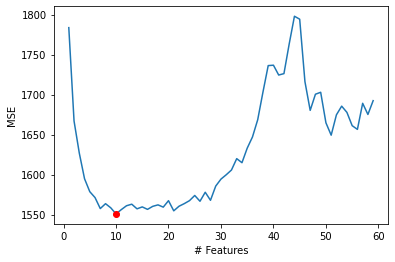

In [45]:
import matplotlib.pyplot as plt

plt.plot(models_fwd["MSE"])
plt.xlabel('# Features')
plt.ylabel('MSE')
plt.plot(models_fwd["MSE"].idxmin(), models_fwd["MSE"].min(), "or")

In [46]:
# Obtaining features of the best model 
best_features = models_fwd.loc[models_fwd['MSE'].idxmin()]['model']
print(len(best_features))
print(best_features)

10
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Property Type_Apartment', 'Property Type_Hotel', 'Accuracy Rating', 'Is Exact Location', 'Property Type_Serviced apartment', 'Property Type_House', 'Neighborhood Group_Marzahn - Hellersdorf']


Based on the graph, the best model is obtained for 10 features. 

Now let's see what features does the RF consider as important :


In [ ]:
pipe = Pipeline([('imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
                 ('scaler',MinMaxScaler()),
                 ('rf', RandomForestRegressor(n_estimators= 300, min_samples_split= 7, min_samples_leaf= 3, max_features='sqrt', max_depth= 30))])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

In [ ]:
importances = list(pipe['rf'].feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(X_train.columns, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: Accomodates          Importance: 0.11
Variable: Bedrooms             Importance: 0.1
Variable: Room Type_Entire home/apt Importance: 0.08
Variable: Room Type_Private room Importance: 0.08
Variable: Beds                 Importance: 0.07
Variable: Bathrooms            Importance: 0.06
Variable: Distance from barycenter Importance: 0.06
Variable: Latitude             Importance: 0.05
Variable: Guests Included      Importance: 0.05
Variable: Host Since           Importance: 0.04
Variable: Longitude            Importance: 0.04
Variable: Reviews              Importance: 0.03
Variable: Min Nights           Importance: 0.02
Variable: Overall Rating       Importance: 0.02
Variable: Property Type_Loft   Importance: 0.02
Variable: Host Response Rate   Importance: 0.01
Variable: Cleanliness Rating   Importance: 0.01
Variable: Location Rating      Importance: 0.01
Variable: Value Rating         Importance: 0.01
Variable: Host Response Time_unknown Importance: 0.01
Variable: Host Response 

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

Here we see a very intersting thing, that the forward feature selection even with n_estimators = 10 noticed that only 10 features were important, and with Random Forest we can see that 25 features have an impact. 

### V/ Rerunning the best version of the algorithm

Therefore, the best algortihm has : 
 - Median imputation 
 - min -max normalization 
 - n_estimators= 300, min_samples_split= 7, min_samples_leaf= 3, max_features='sqrt', max_depth= 30
 - We will compare the results for the features 

First with all the features : 

In [ ]:
pipe = Pipeline([('imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
                 ('scaler',MinMaxScaler()),
                 ('rf', RandomForestRegressor(n_estimators= 300, min_samples_split= 7, min_samples_leaf= 3, max_features='sqrt', max_depth= 30))])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

## Metrics 
mse = mean_squared_error(y_pred, y_test)
mae = mean_absolute_error(y_pred, y_test)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

### Printing the metrics 
print(f'MSE : {mse}')
print(f'MAE : {mae}')
print(f'RMSE: {rmse}')
print(f'R2 Score: {r2}')

MSE : 1007.0294038851101
MAE : 19.68153526472463
RMSE: 31.733726599394377
R2 Score: 0.49144208251487675


With all the features we get a good result : 
- MSE : 1007.0294038851101
- MAE : 19.68153526472463
- RMSE: 31.733726599394377
- R2 Score: 0.49144208251487675


In [ ]:
list_features=[]
for i in range(len(feature_importances)):
    if feature_importances[i][1]>0:
        list_features.append(feature_importances[i][0]) 
print(list_features)

['Accomodates', 'Bedrooms', 'Room Type_Entire home/apt', 'Room Type_Private room', 'Beds', 'Bathrooms', 'Distance from barycenter', 'Latitude', 'Guests Included', 'Host Since', 'Longitude', 'Reviews', 'Min Nights', 'Overall Rating', 'Property Type_Loft', 'Host Response Rate', 'Cleanliness Rating', 'Location Rating', 'Value Rating', 'Host Response Time_unknown', 'Host Response Time_within an hour', 'Property Type_Apartment', 'Property Type_Hotel', 'Property Type_Serviced apartment', 'Neighborhood Group_Mitte', 'Boy or Girl?_Boy', 'Boy or Girl?_Girl']


In [ ]:
pipe = Pipeline([('imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
                 ('scaler',MinMaxScaler()),
                 ('rf', RandomForestRegressor(n_estimators= 300, min_samples_split= 7, min_samples_leaf= 3, max_features='sqrt', max_depth= 30))])

pipe.fit(X_train[list_features], y_train)
y_pred = pipe.predict(X_test[list_features])

## Metrics 
mse = mean_squared_error(y_pred, y_test)
mae = mean_absolute_error(y_pred, y_test)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

### Printing the metrics 
print(f'MSE : {mse}')
print(f'MAE : {mae}')
print(f'RMSE: {rmse}')
print(f'R2 Score: {r2}')

MSE : 1015.8466948031265
MAE : 19.67591384347838
RMSE: 31.87235000440235
R2 Score: 0.48698927995536134


Therefore with our optimized algorithm having lower feature we get the results :
 
- MSE : 1015.8466948031265
- MAE : 19.67591384347838
- RMSE: 31.87235000440235
- R2 Score: 0.48698927995536134

Now lets try with the features returned by the forward selection 

In [47]:
from csv import list_dialects
list_features_FS= best_features
print(list_features_FS)
print(len(list_features_FS))

['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Property Type_Apartment', 'Property Type_Hotel', 'Accuracy Rating', 'Is Exact Location', 'Property Type_Serviced apartment', 'Property Type_House', 'Neighborhood Group_Marzahn - Hellersdorf']
10


In [48]:
pipe = Pipeline([('imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
                 ('scaler',MinMaxScaler()),
                 ('rf', RandomForestRegressor(n_estimators= 300, min_samples_split= 7, min_samples_leaf= 3, max_features='sqrt', max_depth= 30))])

pipe.fit(X_train[list_features_FS], y_train)
y_pred = pipe.predict(X_test[list_features_FS])

## Metrics 
mse = mean_squared_error(y_pred, y_test)
mae = mean_absolute_error(y_pred, y_test)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

### Printing the metrics 
print(f'MSE : {mse}')
print(f'MAE : {mae}')
print(f'RMSE: {rmse}')
print(f'R2 Score: {r2}')

MSE : 1084.2303287566526
MAE : 20.550931479569435
RMSE: 32.92765294940793
R2 Score: 0.45245499690533253


By trying with the best features selection, we get a worse RMSE. 
**The Best results are when we keep all the features !** ( Proving that Random Forest is not so much touched by the curse of dimension ) 

## VI/ Analysis of the outcome 

Now that we have optimized our algorithm as much as possible, we will analyze the predictions

In [ ]:
pipe = Pipeline([('imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
                 ('scaler',MinMaxScaler()),
                 ('rf', RandomForestRegressor(n_estimators= 300, min_samples_split= 7, min_samples_leaf= 3, max_features='sqrt', max_depth= 30))])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
## Metrics 
mse = mean_squared_error(y_pred, y_test)
mae = mean_absolute_error(y_pred, y_test)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
adjusted_r2 = 1 - (1-r2)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)

### Printing the metrics 
print(f'MSE : {mse}')
print(f'MAE : {mae}')
print(f'RMSE: {rmse}')
print(f'R2 Score: {r2}')
print(f'Adjusted R2-score : {adjusted_r2}')

MSE : 1003.9108211652101
MAE : 19.643441110382245
RMSE: 31.6845517747247
R2 Score: 0.49301699177514147
Adjusted R2-score : 0.48302634465247396


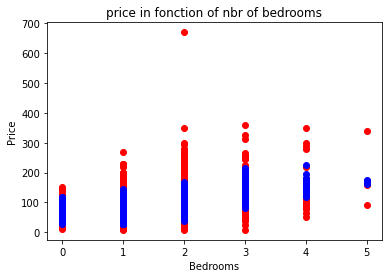

In [ ]:
plt.scatter(X_test['Bedrooms'],y_test, color='red') #plotting real points
plt.scatter(X_test['Bedrooms'], y_pred ,color='blue') #plotting f

plt.title("price in fonction of nbr of bedrooms")
plt.xlabel('Bedrooms')
plt.ylabel('Price')
plt.show()

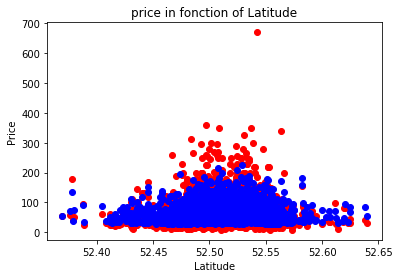

In [ ]:
plt.scatter(X_test['Latitude'],y_test, color='red') #plotting real points
plt.scatter(X_test['Latitude'], y_pred,color='blue') #plotting f


plt.title("price in fonction of Latitude")
plt.xlabel('Latitude')
plt.ylabel('Price')
plt.show()

We see here that RF is good at getting the general tendancy, and does not overfit as it doesn't get the outliers 

In [ ]:
# Visualisation of a part of the random forest
from sklearn.tree import export_graphviz
import pydot

tree = pipe['rf'].estimators_[15]
export_graphviz(tree, out_file = 'tree.dot', feature_names = X_train.columns, rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('tree.dot')
graph.write_png('tree.png')

Here we can have the visualisation of one of the tree of our forest. ( I wanted to insert the picture but colab froze when I added it ) 

### VI/ SHAPLEY VALUES 

In [38]:
!pip install shap 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 8.5 MB/s 


Shapley values for random forest are very sensible to max_depth. If max_depth is too high it will run for hours, so we will do the shapley values for max_depth = 5, just to get a general idea of how to explain our features 

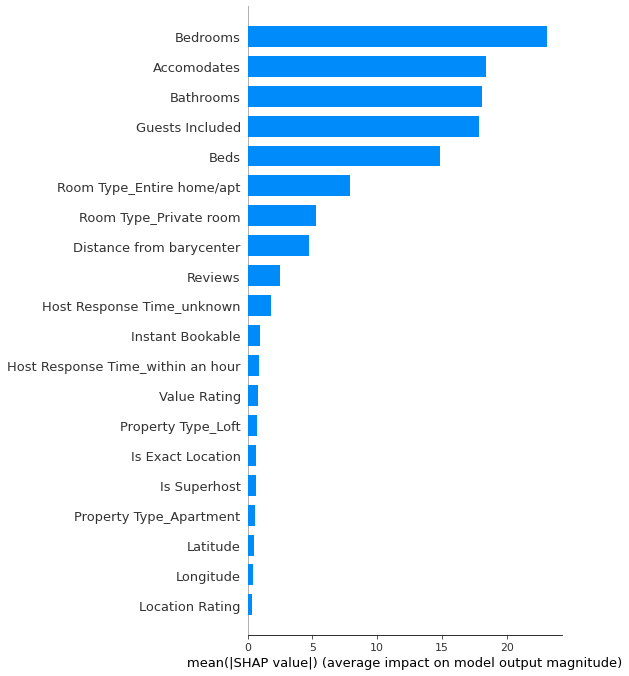

In [39]:
import shap
pipe = Pipeline([('imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
                 ('scaler',MinMaxScaler()),
                 ('rf', RandomForestRegressor(n_estimators= 300, min_samples_split= 7, min_samples_leaf= 3, max_features='sqrt', max_depth= 5))])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

explainer = shap.TreeExplainer( pipe['rf'] )
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train, plot_type="bar")

In [40]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

With the Shapley values we can go one step further and really understand what impacts our predictions and how. Here for instance we see that the more a listing accomodates people the more the price will be higher, however the number of bedrooms is important and if it is low the price gets lower too. 
( People want a listing that can accomodate them if they are a large groupe but without having to all sleep in the same room I suppose )  
